In [1]:
import torch
import gnn
import data 
import utils  
data.sc.settings.verbosity = 0

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [2]:
n_genes = None

In [3]:
if n_genes is None: 
    adata = data.preprocess_paul15(data.get_paul15()) 
else: 
    adata = data.preprocess_paul15(data.get_paul15(), n_top_genes=n_genes) 

target_col_categories = 'paul15_clusters'
target_col = 'paul15_clusters_ind'

n_train_perc = 0.7
n_train = int(n_train_perc * adata.X.shape[0])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.tensor(adata.X).to(device)
y = data.target2onehot(adata, target_col=target_col).to(device)


/home/hbl/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/usr/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/data.py:132: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['paul15_clusters_ind'] = adata.obs.paul15_clusters.replace(cats.to_list(), range(len(cats)))


In [4]:
adata = data.preprocess_leiden(adata, n_neighbors=30)
edge_index = data.connectivities2edge_index(adata).to(device)

In [8]:
NUM_EPOCHS = 2001
LR = 0.001
input_dim = x.shape[1]
output_dim = data.num_categories(adata, target_col=target_col_categories)

In [6]:
models = []
for i in [1, 2, 3, 4, 5, 6]:
    utils.seed(0)
    models.append(gnn.GNN('GCN', input_dim, output_dim, num_layers=i, hidden_dim=64).to(device))

In [7]:

objs = []
for model in models: 
    utils.seed(0)
    obj = gnn.train(model, x, edge_index, y, n_train, lr=LR, num_epochs=NUM_EPOCHS, log_interval=1000)
    objs.append(obj)

[EPOCH 0] train loss: 2.953526496887207
[EPOCH 1000] train loss: 2.5680501461029053
[EPOCH 2000] train loss: 2.4455926418304443
[EPOCH 0] train loss: 2.9537785053253174
[EPOCH 1000] train loss: 2.527111053466797
[EPOCH 2000] train loss: 2.509181022644043
[EPOCH 0] train loss: 2.941617012023926
[EPOCH 1000] train loss: 2.5219879150390625
[EPOCH 2000] train loss: 2.5068016052246094
[EPOCH 0] train loss: 2.9439566135406494
[EPOCH 1000] train loss: 2.6314330101013184
[EPOCH 2000] train loss: 2.618530511856079
[EPOCH 0] train loss: 2.946692943572998
[EPOCH 1000] train loss: 2.628065347671509
[EPOCH 2000] train loss: 2.538970708847046
[EPOCH 0] train loss: 2.9482502937316895
[EPOCH 1000] train loss: 2.742229700088501
[EPOCH 2000] train loss: 2.705380439758301


oversmoothing metrics

In [8]:
outputs = []
with torch.no_grad(): 
    for model in models: 
        outputs.append(model(x, edge_index))

In [103]:
import pandas as pd 
import torch.nn.functional as F 

def class_accuracies_multi(labels, predictions_list, unique_labels): 
    df = pd.DataFrame({'label': labels, 'count': torch.zeros_like(labels)})

    n = len(predictions_list) + 1
    fig, ax = plt.subplots(1, n, figsize=(4*n, 4))
    for i,predictions in enumerate(predictions_list): 
        df2 = pd.concat([df[['label']], pd.DataFrame(F.one_hot(predictions, num_classes=len(unique_labels)).numpy())], axis=1)
        df_pred_count = pd.merge(df.groupby('label').count(), df2.groupby('label').sum(), on='label')
        df_pred_acc = df_pred_count.copy()
        for l in unique_labels: 
            df_pred_acc[l] /= df_pred_acc['count']
        df_pred_acc.drop('count', axis=1, inplace=True)

        ax[i].imshow(df_pred_acc.transpose(), cmap='hot')
        ax[i].set_xlabel('label')
        if i == 0:
            ax[i].set_ylabel('prediction')
    ax[i+1].bar(df_pred_count.index, df_pred_count['count'], )
    ax[i+1].set_xlabel('label')
    ax[i+1].yaxis.tick_right()
    ax[i+1].set_ylabel('data count')
    ax[i+1].yaxis.set_label_position("right")

    # fig, ax = plt.subplot_mosaic([['counts', 'accs']], constrained_layout=True, sharex=True, 
    #     gridspec_kw={'width_ratios':(1,2)}, figsize=(10, 6))
    # ax['counts'].bar(df_pred_count.index, df_pred_count['count'], )
    # # ax['counts'].barh(df_pred_count['count'], df_pred_count.index)
    # ax['counts'].set_ylabel(('count'))
    # ax['counts'].set_xlabel(('label'))
    # ax['accs'].imshow(df_pred_acc.transpose(), cmap='hot')
    # # ax['accs'].grid(False)
    # ax['accs'].set_ylabel('prediction')
    # ax['accs'].set_xlabel('label')
    # ax['accs'].sharex(ax['counts'])
    # fig.suptitle('Class label counts and prediction percentages')

    return fig, ax


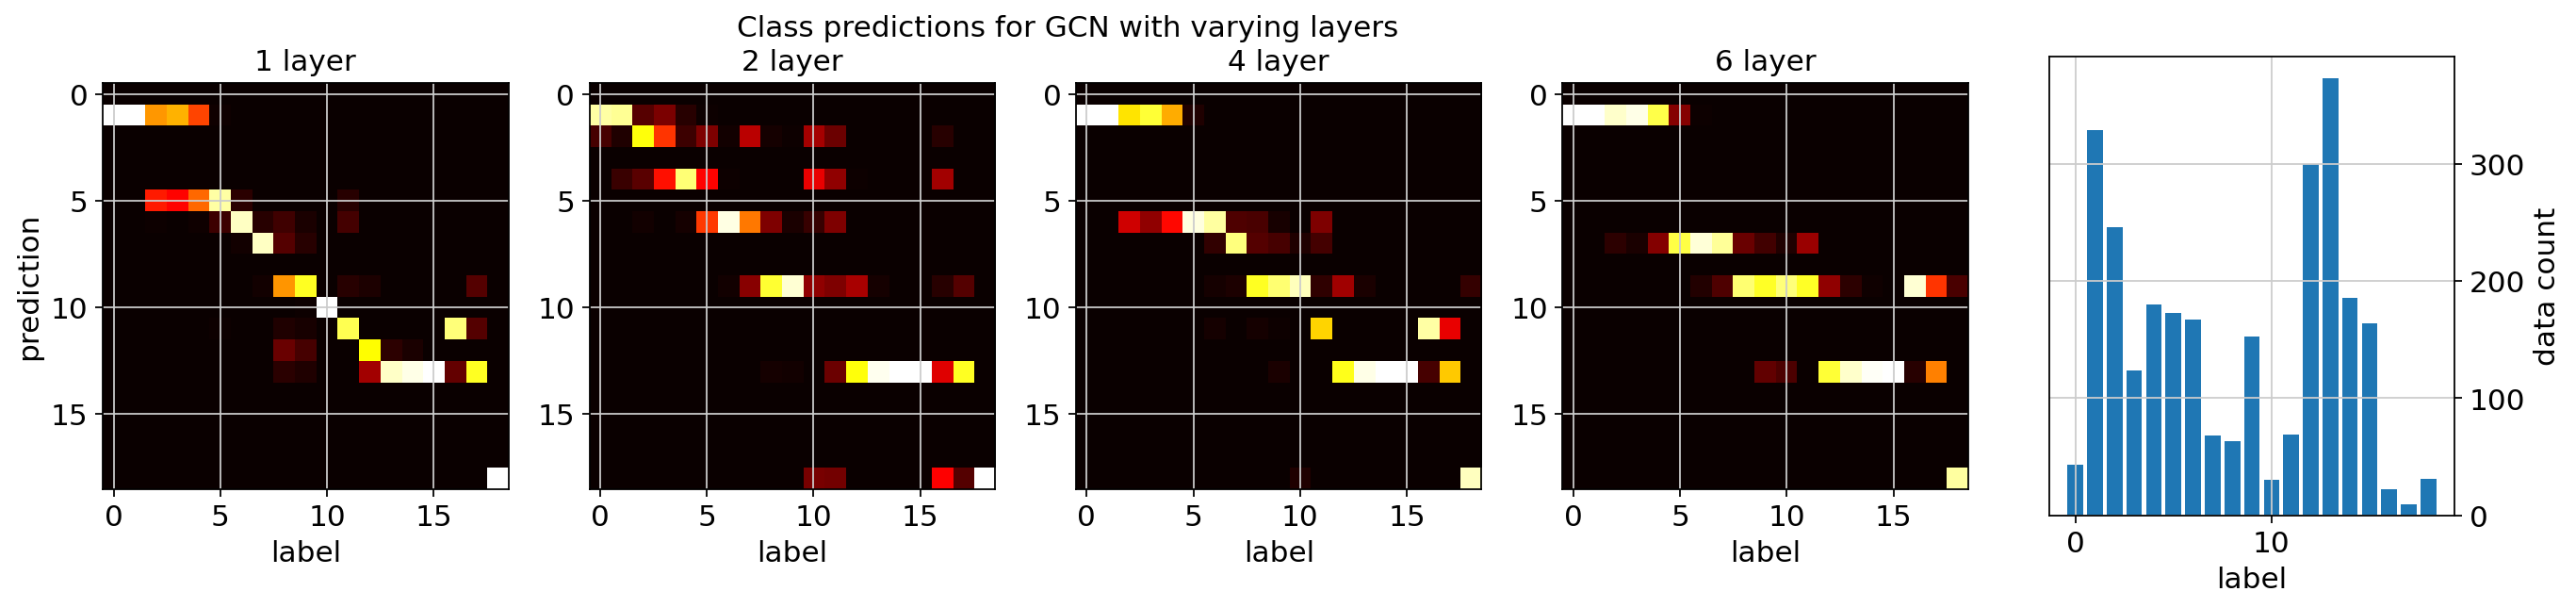

In [106]:
fig, ax = class_accuracies_multi(y.argmax(1).cpu(), 
    [outputs[0].argmax(1).cpu(), outputs[1].argmax(1).cpu(), outputs[3].argmax(1).cpu(), outputs[5].argmax(1).cpu()], 
    list(range(19))
)
ax[0].set_title('1 layer')
ax[1].set_title('2 layer')
ax[2].set_title('4 layer')
ax[3].set_title('6 layer')
fig.suptitle('Class predictions for GCN with varying layers')
fig.savefig('./plots/gcn-oversmoothing.png')

[<AxesSubplot:xlabel='label', ylabel='prediction'>,
 <AxesSubplot:xlabel='label', ylabel='prediction'>]

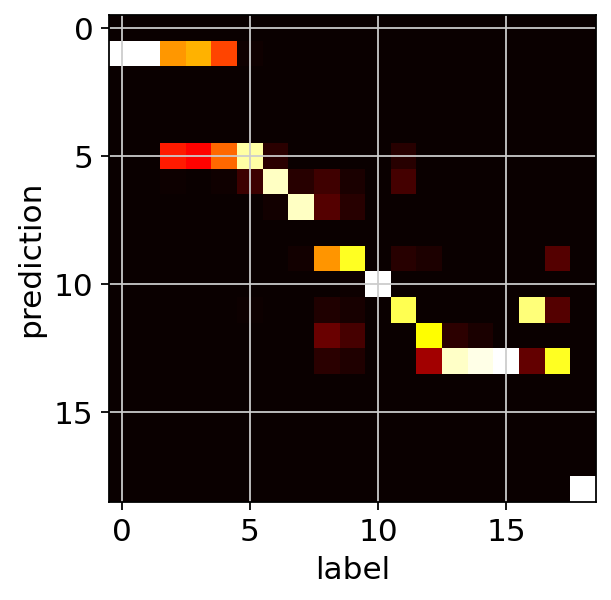

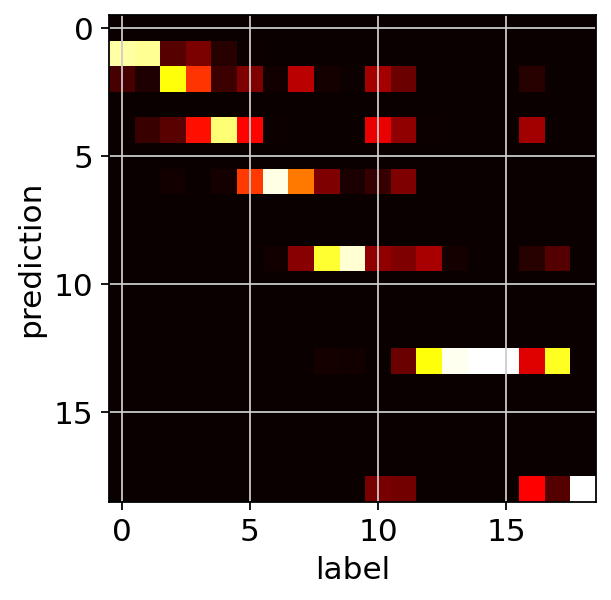

In [72]:
fig, ax = class_accuracies_multi(y.argmax(1).cpu(), outputs[0].argmax(1).cpu(), list(range(19)))
fig, ax2 = class_accuracies_multi(y.argmax(1).cpu(), outputs[1].argmax(1).cpu(), list(range(19)))


group distance

In [6]:
# from torch_geometric.nn import DiffGroupNorm

# https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/norm/diff_group_norm.html#DiffGroupNorm
def group_distance_ratio(x, y, eps: float = 1e-5, num_classes = None) -> float:
    r"""Measures the ratio of inter-group distance over intra-group
    distance

    .. math::
        R_{\text{Group}} = \frac{\frac{1}{(C-1)^2} \sum_{i!=j}
        \frac{1}{|\mathbf{X}_i||\mathbf{X}_j|} \sum_{\mathbf{x}_{iv}
        \in \mathbf{X}_i } \sum_{\mathbf{x}_{jv^{\prime}} \in \mathbf{X}_j}
        {\| \mathbf{x}_{iv} - \mathbf{x}_{jv^{\prime}} \|}_2 }{
        \frac{1}{C} \sum_{i} \frac{1}{{|\mathbf{X}_i|}^2}
        \sum_{\mathbf{x}_{iv}, \mathbf{x}_{iv^{\prime}} \in \mathbf{X}_i }
        {\| \mathbf{x}_{iv} - \mathbf{x}_{iv^{\prime}} \|}_2 }

    where :math:`\mathbf{X}_i` denotes the set of all nodes that belong to
    class :math:`i`, and :math:`C` denotes the total number of classes in
    :obj:`y`.
    """
    if num_classes is None: 
        num_classes = int(y.max()) + 1

    numerator = 0.
    for i in range(num_classes):
        mask = y == i
        dist = torch.cdist(x[mask].unsqueeze(0), x[~mask].unsqueeze(0))
        if dist.numel() == 0: 
            continue
        numerator += (1 / dist.numel()) * float(dist.sum())
    numerator *= 1 / (num_classes - 1)**2

    denominator = 0.
    for i in range(num_classes):
        mask = y == i
        dist = torch.cdist(x[mask].unsqueeze(0), x[mask].unsqueeze(0))
        if dist.numel() == 0: 
            continue
        denominator += (1 / dist.numel()) * float(dist.sum())
    denominator *= 1 / num_classes

    return y.unique().size(0), numerator / (denominator + eps)

In [44]:
num_labels = y.argmax(1).unique().size(0)
group_distance_ratio(x, y.argmax(axis=1), num_classes=num_labels)

(19, 0.06544348437208056)

In [45]:
# want it to be high for better discrimination? 
for yhat in outputs: 
    print(group_distance_ratio(x, yhat.argmax(axis=1), num_classes=num_labels))

(10, 0.06297306446213202)
(7, 0.06397240073151213)
(7, 0.06526202267178433)
(7, 0.0624549996326331)
(7, 0.06575417047096936)
(5, 0.06397528004302609)


look at group distance over epochs

In [9]:
import numpy as np 
utils.seed(0)
model = gnn.GNN('GCN', input_dim, output_dim, num_layers=2, hidden_dim=64).to(device)

epoch_intervals = np.arange(100, 2001, 100)
epoch_steps = epoch_intervals[1:] - epoch_intervals[:-1]
gds = []
for epochs in epoch_steps: 
    gnn.train(model, x, edge_index, y, n_train, lr=LR, num_epochs=epochs, log_interval=1000)
    yhat = model(x, edge_index)
    gds.append(group_distance_ratio(x, yhat.argmax(axis=1)))

[EPOCH 0] train loss: 2.9537785053253174
[EPOCH 0] train loss: 2.7011983394622803
[EPOCH 0] train loss: 2.5625112056732178
[EPOCH 0] train loss: 2.49520206451416
[EPOCH 0] train loss: 2.4811911582946777
[EPOCH 0] train loss: 2.4650487899780273
[EPOCH 0] train loss: 2.4586281776428223
[EPOCH 0] train loss: 2.4515061378479004
[EPOCH 0] train loss: 2.4451863765716553
[EPOCH 0] train loss: 2.4405550956726074
[EPOCH 0] train loss: 2.4363768100738525
[EPOCH 0] train loss: 2.433433771133423
[EPOCH 0] train loss: 2.430962085723877
[EPOCH 0] train loss: 2.4283244609832764
[EPOCH 0] train loss: 2.4263622760772705
[EPOCH 0] train loss: 2.4248552322387695
[EPOCH 0] train loss: 2.4232845306396484
[EPOCH 0] train loss: 2.421919584274292
[EPOCH 0] train loss: 2.42029070854187


In [12]:
import matplotlib.pyplot as plt

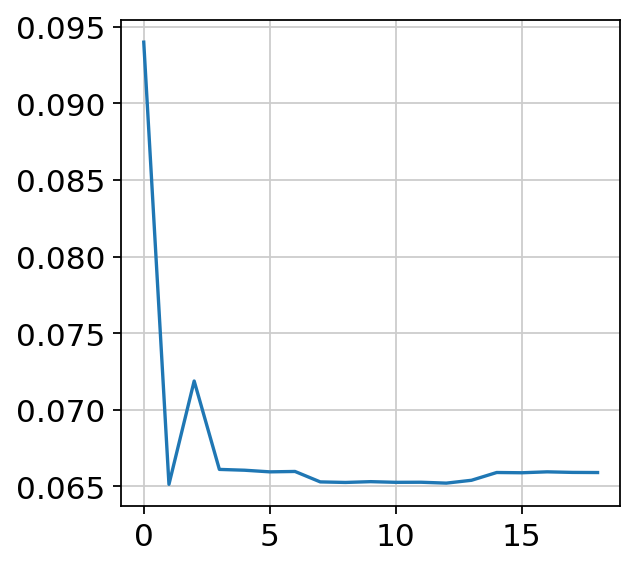

In [14]:
plt.plot([i[1] for i in gds])